In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

from tqdm import tqdm

/home/s.gostilovich/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda:1' #torch.device(torch.cuda.get_device_name(1))

# Low Rank Autoencoder

### Blocked autoencoder

In [11]:
class EncoderDecoder(nn.Module):
    def __init__(self, in_features, out_features, nonlinearity):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features   
        self.nonlinearity = nonlinearity
        
        self.encoder_decoder = nn.Sequential(nn.Linear(in_features, out_features),
                                     nonlinearity,
                                     nn.Linear(out_features, out_features))
    
    def forward(self, x):
        return self.encoder_decoder(x)

In [4]:
torch.tensor([[1, 2, 3, 4, 5,], [6, 7, 8, 9, 10]]).prod(0)

tensor([ 6, 14, 24, 36, 50])

In [5]:
p_dist = torch.tensor([0, 0, 0, 1, 1, 2, 3, 3, 3, 3, 3, 2, 0, 0, 1, 1, 1, 1, 0, 0]).reshape(1, 1, -1)
p_dist = p_dist.expand([1,2, p_dist.shape[-1]])
p_dist.shape
normalized_factors = p_dist/p_dist.sum(-1, keepdim=True)
temperature = 0.01

normalized_factors = normalized_factors.to(device)


In [ ]:
grid = (torch.arange(20)*1.).to(device)

In [ ]:
proba_encoded = final_factors * normalized_factors 
proba_encoded[0, 0, :]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0400, 0.0000, 0.0000,
        0.0000, 0.0000], device='cuda:1')

In [ ]:

eps = 1e-20
logit_factors = torch.log(normalized_factors+eps) 
y_unit = torch.rand(logit_factors.shape).to(device)
y_logs = -torch.log(-torch.log(y_unit + eps) + eps)
final_factors = torch.softmax((logit_factors + y_logs)/temperature, dim=-1)
proba_encoded = final_factors * normalized_factors
print(proba_encoded[0, 0, :])
proba_encoded = proba_encoded.prod(-2, keepdim=True)
print(proba_encoded[0, 0, :])
encoded = (final_factors*proba_encoded) @ grid

print(encoded[0, :])

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2000e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.2641e-12, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00], device='cuda:1')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:1')
tensor([0., 0.], device='cuda:1')


In [ ]:
encoded.shape

torch.Size([1, 2])

In [12]:
# DIFFERENT SAMPLING FUNCTIONS

def vector_sampling(normalized_factors, grid):
    encoded = normalized_factors @ grid
    return encoded

def softmax_sampling(normalized_factors, grid, temperature=0.01):
    B, out_features, n_bins = normalized_factors.shape
    cumsum_factors = torch.cumsum(normalized_factors, dim=-1)          # cumsum over bins
    y = torch.rand(B, out_features,1).to(device)                       # uniform random 
    abs_factors = torch.abs(cumsum_factors - y)                        # finding closest x via argmax
    final_factors = torch.softmax(-abs_factors/temperature, dim=-1)
    encoded = final_factors @ grid
    return encoded

def gumbell_sampling(normalized_factors, grid, temperature=0.01):
    eps = 1e-20
    logit_factors = torch.log(normalized_factors+eps) 
    y_unit = torch.rand(logit_factors.shape).to(device)
    y_logs = -torch.log(-torch.log(y_unit + eps) + eps)
    final_factors = torch.softmax((logit_factors + y_logs)/temperature, dim=-1)
    encoded = final_factors @ grid
    return encoded



def gumbell_sampling_v2(normalized_factors, grid, temperature=0.01):
    eps = 1e-20
    logit_factors = torch.log(normalized_factors+eps) 
    y_unit = torch.rand(logit_factors.shape).to(device)
    y_logs = -torch.log(-torch.log(y_unit + eps) + eps)
    final_factors = torch.softmax((logit_factors + y_logs)/temperature, dim=-1)
    proba_encoded = final_factors @ normalized_factors
    print(proba_encoded[0, :, :])
    proba_encoded = proba_encoded.prod(-1)
    print(proba_encoded[0, :,])

    
    encoded = final_factors @ grid
    
    
    return encoded



# SHIFTED MASKING FUNCTION - didn't prove to be of much help
def masking(normalized_factors, mask_size):
    B, out_features, n_bins = normalized_factors.shape
    assert n_bins % mask_size == 0 , f'n_bins={n_bins} must be divisible by mask_size={mask_size}'
    eps = 1e-9
    mask = torch.ones(B, out_features, n_bins).to(device)
    mask[::,::,0:mask_size] = 0
    mask = torch.roll(mask, torch.randint(low=0,high=n_bins-mask_size+1, size=(1,)).item(), dims=-1)
    dropped_factors = mask*normalized_factors + eps
    return dropped_factors

In [13]:
# Low Rank Pants class
class LowRankPants(nn.Module):
    def __init__(self, inter_features, out_features, n_bins, dropout, sampling, temperature):
        super().__init__()
        self.inter_features = inter_features
        self.out_features = out_features
        self.n_bins = n_bins
        self.dropout = dropout
        # sampling
        self.sampling = sampling
        self.temperature = temperature
        
        assert sampling in {'vector', 'softmax', 'gumbell'}, 'No such sampling method, select vector, softmax, gumbell'
        
        # coeff for logarithms
        self.eps = 1e-4/(n_bins*out_features)
        
        # coord grid
        grid = (torch.arange(1,n_bins+1)).to(device)
        self.grid = grid /n_bins
        
        # mapping to final probabilities (штаны)
        self.layers = nn.ModuleList([nn.Sequential(
                                                   nn.Linear(inter_features, n_bins),
                                                   nn.Sigmoid()
                                                  )
                                                   for i in range(out_features)]
                                   )

        # dropout for randromized sampling
        self.dropout = nn.Dropout(dropout)
        
    # even faster forward - inner products with the range vec
    def forward(self,x):
        B = x.shape[0]

        # getting additional linear layer
        factors_list = []
        for layer in self.layers:
            factors_list.append(layer(x)) # (B, n_bins)
        # stack  them up
        factors = torch.stack(factors_list, dim=-1)
        factors_reshaped = factors.view(B, self.out_features, self.n_bins) # size = (B, out_features, n_bins)
        factors_probability = factors_reshaped/(torch.sum(factors_reshaped, dim=-1, keepdim=True))
        
        # randomized selection + added eps
        dropped_factors = self.dropout(factors_probability) + self.eps
        
        # normalization
        normalized_drop_factors = dropped_factors/(torch.sum(dropped_factors, dim=-1, keepdim=True))
        
        # choosing the sampling
        if self.sampling == 'vector':
            encoded =  vector_sampling(normalized_drop_factors, self.grid)
        elif self.sampling == 'softmax':
            encoded = softmax_sampling(normalized_drop_factors, self.grid, self.temperature)
        elif self.sampling == 'gumbell':
            encoded = gumbell_sampling(normalized_drop_factors, self.grid, self.temperature)
        elif self.sampling == 'gumbell_v2':
            encoded = gumbell_sampling_v2(normalized_drop_factors, self.grid, self.temperature)
        
        return encoded, factors_probability

In [14]:
class LowRankAutoencoder(nn.Module):
    def __init__(self, in_features, inter_features, out_features, n_bins,
                 dropout, nonlinearity,
                 sampling, temperature):
        super().__init__() 
        # network feature sizes
        self.in_features = in_features
        self.inter_features = inter_features
        self.out_features = out_features
        self.n_bins = n_bins
        # network params
        self.nonlinearity = nonlinearity
        self.dropout = dropout
        # sampling params
        self.sampling = sampling
        self.temperature = temperature
        
        # encoder
        self.encoder = EncoderDecoder(in_features, inter_features, nn.ELU())
        
        # low rank probabilites
        self.low_rank_pants = LowRankPants(inter_features, out_features, n_bins, dropout, sampling, temperature)
        
        # intermediate_decoder
        self.intermediate_decoder = EncoderDecoder(out_features, inter_features, nn.ELU())
        
        # final decoder
        self.decoder = EncoderDecoder(inter_features, in_features, nn.ELU())
        
    def forward(self, x):
        encoded_inter_dim = self.encoder(x)
        encoded_out_dim, factors_probability = self.low_rank_pants(encoded_inter_dim)
        decoded_inter_dim = self.intermediate_decoder(encoded_out_dim)
        decoded = self.decoder(decoded_inter_dim)
        return decoded

In [15]:
LRA = LowRankAutoencoder(in_features=10, inter_features=20, out_features=2, n_bins=20,
                         dropout=0.2, nonlinearity=nn.ELU(),
                         sampling='vector', temperature=0.1).to(device)

ttt = torch.rand(16, 10).to(device)
LRA(ttt).shape

torch.Size([16, 10])

# Convolutional autoencoder
## Up and Down Blocks

In [16]:
class DownsampleBlock(nn.Module):
    def __init__(self, in_features, out_features, nonlinearity=nn.ELU()):
        super().__init__()
        self.conv = nn.Conv2d(in_features, out_features,
                               kernel_size=4, stride=2, padding=1, dilation=1)
        self.nonlinearity = nonlinearity
    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.nonlinearity(x1)
        return x2

In [17]:
class UpsampleBlock(nn.Module):
    def __init__(self, in_features, out_features, scale_factor=2, nonlinearity=nn.ELU()):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(in_features, out_features,
                                            kernel_size=4, output_padding=0, padding=1, stride=2)
        self.nonlinearity = nonlinearity
    def forward(self, x):
        x1 = self.upsample(x)
        x2 = self.nonlinearity(x1)
        return x2

In [18]:
db = DownsampleBlock(in_features=8, out_features=8)
ttt = torch.rand(16,8,32,32)
db(db(db(ttt))).shape

torch.Size([16, 8, 4, 4])

In [19]:
ub = UpsampleBlock(in_features=8, out_features=8,)

ub(ub(ub(db(db(db(ttt)))))).shape

torch.Size([16, 8, 32, 32])

In [20]:
class ConvLRAE(nn.Module):
    def __init__(self, in_features, inter_features, out_features, n_bins,
                 dropout, nonlinearity,
                 sampling='vector', temperature=0.1,
                img_size=(24,24)):
        super().__init__()
        
        self.in_features = in_features   # input features after convolutions and flattening
        self.out_features = out_features # encoded dimension
        self.n_bins = n_bins
        # for flattening
        self.img_size = img_size
        self.flat_size = img_size[0]//8
        # network params
        self.nonlinearity = nonlinearity
        self.dropout = dropout
        # sampling params
        self.sampling = sampling
        self.temperature = temperature

        
        self.down = nn.Sequential(
                                  DownsampleBlock(in_features=1, out_features=32, nonlinearity=nonlinearity),
                                  DownsampleBlock(in_features=32, out_features=64, nonlinearity=nonlinearity),
                                  DownsampleBlock(in_features=64, out_features=64, nonlinearity=nonlinearity),
                                  )
        
        self.low_rank = LowRankAutoencoder(in_features, inter_features, out_features, n_bins,
                                           dropout, nonlinearity,
                                           sampling, temperature)
        
        self.up = nn.Sequential(
                                UpsampleBlock(in_features=64, out_features=64, nonlinearity=nonlinearity),
                                UpsampleBlock(in_features=64, out_features=32, nonlinearity=nonlinearity),
                                UpsampleBlock(in_features=32, out_features=1,  nonlinearity=nn.Tanh()),
                                )
        
    def forward(self, x):
        # downsample
        x_down = self.down(x)
        B, C, H, W = x_down.shape
        x_flat = x_down.view(B,C*H*W)
        
        # passing theough low rank
        decoded = self.low_rank(x_flat)

        # upsample
        x_2d = decoded.view(B, C, H, W)
        x_out = self.up(x_2d)

        return x_out
            
            

In [21]:
mdl = ConvLRAE(in_features=64*4*4, inter_features=256, out_features=4, n_bins=20,
                dropout=0.1, nonlinearity=nn.ReLU()
              ).to(device)

ttt = torch.randn(10, 1, 32, 32).to(device)

mdl(ttt).shape

torch.Size([10, 1, 32, 32])

### Dataset class

In [22]:
from torch.utils.data import Dataset, DataLoader

class MNIST_DS(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float)
        self.X = self.X/torch.max(self.X) # normalizing to 1.
        self.Y = torch.tensor(Y, dtype=torch.long)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        x, y = self.X[idx], self.Y[idx]
        return x,y

### Torchvision dataset

In [23]:
import torchvision
from torchvision import transforms
from torch.utils.data import Subset, Dataset, DataLoader

train_ds_mnist = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                                 transforms.Resize(32),
                                 torchvision.transforms.ToTensor(),
                             ]))
test_ds_mnist = torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                                 transforms.Resize(32),
                                 torchvision.transforms.ToTensor(),
                             ]))

# dataset and dataloader
TRAIN_SIZE = 60000
TEST_SIZE = 5000
BATCH_SIZE = 512
dl = DataLoader(train_ds_mnist, batch_size=BATCH_SIZE,     num_workers=10)
dl_test = DataLoader(test_ds_mnist, batch_size=BATCH_SIZE, num_workers=10)

#full dataset train
FULL_TRAIN_SIZE = 60000
dl_full = DataLoader(train_ds_mnist, batch_size=FULL_TRAIN_SIZE)
for x, y in dl_full:
    X_full_train = x
    targets = y
    break

#full dataset train
FULL_TEST_SIZE = 5000
dl_full = DataLoader(test_ds_mnist, batch_size=FULL_TEST_SIZE)
for x, y in dl_full:
    X_full_test = x
    targets_test = y
    break

# print(X_full.shape)
# print(torch.max(X_full))
print(targets.unique(return_counts=True))

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))


In [24]:
torch.manual_seed(0)

In [46]:
torch.cuda.empty_cache()

model = ConvLRAE(in_features=1024, inter_features=256, out_features=4, n_bins=20,
                dropout=0.3, nonlinearity=nn.ReLU(),
                sampling='gumbell', temperature=0.1,
                ).to(device)


criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [47]:
def inf_by_layers(model, x_batch):
    # forward pass with intermediate layers
    x_down = model.down(x_batch)
    B, C, H, W = x_down.shape
    x_flat = x_down.view(B,C*H*W)
    encoded_inter_dim =                    model.low_rank.encoder(x_flat)
    encoded_out_dim, factors_probability = model.low_rank.low_rank_pants(encoded_inter_dim)
    decoded_inter_dim =                    model.low_rank.intermediate_decoder(encoded_out_dim)
    decoded_1d =                           model.low_rank.decoder(decoded_inter_dim)
    decoded_2d_small = decoded_1d.view(B, C, H, W)
    decoded_2d = model.up(decoded_2d_small)

    return decoded_2d, encoded_out_dim, factors_probability

In [48]:
loss_list_train = []
loss_train_cum = 0

loss_list_test = []
loss_test_cum = 0

In [49]:
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
EPOCHS = 100
model.train()

# loss_list_train = []
# loss_train_cum = 0

# loss_list_test = []
# loss_test_cum = 0
i = 0

for epoch in tqdm(range(EPOCHS)):
    # Forward pass: Compute predicted y by passing x to the model
    
    for x_batch, y_batch in dl:
        model.train()

        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        # model forward
        # x_decoded = model(x_batch)
        x_decoded, encoded_out_dim, factors_probability = inf_by_layers(model, x_batch)
         
        
        loss = criterion(x_decoded.view(-1), x_batch.view(-1))
        
        
        
         
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # accumulate loss
        loss_train_cum += loss.item()
        
        # validation and saving
        i += 1
        if i % 100 == 0:
            loss_list_train.append(loss_train_cum/100)
            loss_train_cum = 0
            with torch.no_grad():
                model.eval() # put to eval
                for x_batch, y_batch in dl_test:
                    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                    
                    # model forward
                    # x_decoded = model(x_batch)
                    x_decoded, encoded_out_dim, factors_probability = inf_by_layers(model, x_batch)

                    loss_test = criterion(x_decoded.view(-1), x_batch.view(-1))
                    loss_test_cum += loss_test.item()
                model.train() # put back to train
            # save to list
            loss_list_test.append(loss_test_cum/len(dl_test))
            loss_test_cum = 0
            
    #     break
    # break

100%|██████████| 100/100 [06:55<00:00,  4.16s/it]


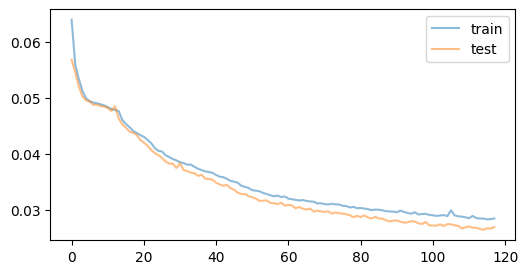

In [50]:
plt.figure(figsize=(6,3))
plt.plot(loss_list_train, alpha=0.5, label='train')
plt.plot(loss_list_test, alpha=0.5, label='test')
# plt.yscale('log')
plt.legend()
plt.savefig('MNIST_softmax_plus_loss.png')
plt.show()

### Reconstruction and distribution graphs

In [51]:
def inf_by_layers(model, x_batch):
    # forward pass with intermediate layers
    x_down = model.down(x_batch)
    B, C, H, W = x_down.shape
    x_flat = x_down.view(B,C*H*W)
    encoded_inter_dim =                    model.low_rank.encoder(x_flat)
    encoded_out_dim, factors_probability = model.low_rank.low_rank_pants(encoded_inter_dim)
    decoded_inter_dim =                    model.low_rank.intermediate_decoder(encoded_out_dim)
    decoded_1d =                           model.low_rank.decoder(decoded_inter_dim)
    decoded_2d_small = decoded_1d.view(B, C, H, W)
    decoded_2d = model.up(decoded_2d_small)

    return decoded_2d, encoded_out_dim, factors_probability

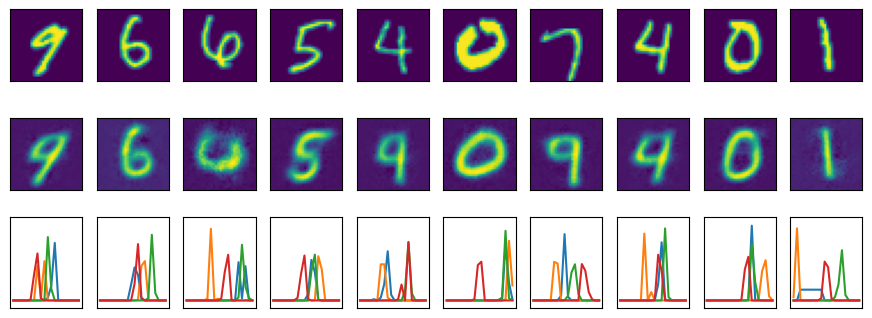

In [54]:
fig, axs = plt.subplots(3,10, figsize=(11,4))

for i in range(0,10):
    INDX=i+20
    #true
    
    #pred
    with torch.no_grad():
        model.eval()
        x_batch = X_full_test[INDX].unsqueeze(0).to(device)
        
        # plotting original images
        axs[0,i].imshow(x_batch[0,0].cpu().detach().numpy()) # mnist

        # forward pass with intermediate layers
        decoded_2d, encoded_out_dim, factors_probability = inf_by_layers(model, x_batch)
        
    axs[1,i].imshow(decoded_2d.cpu().detach().numpy()[0,0]) # mnist

    
    # 1d probabilities
    for j in range(factors_probability.shape[1]):
        axs[2,i].plot(factors_probability[0,j,::].cpu().detach().numpy())
        axs[2,i].set_ylim(-0.1,1.1)
        
    axs[0,i].set_xticks([])
    axs[0,i].set_yticks([])
    axs[1,i].set_xticks([])
    axs[1,i].set_yticks([])
    axs[2,i].set_xticks([])
    axs[2,i].set_yticks([])

# plt.savefig('MNIST_softmax_plus_Reconstruction.png')
plt.show()

In [55]:
# forward whole dataset
with torch.no_grad():
    model.eval()
    # mnist
    decoded_2d, encoded_out_dim, factors_probability = inf_by_layers(model, X_full_test.to(device))
    


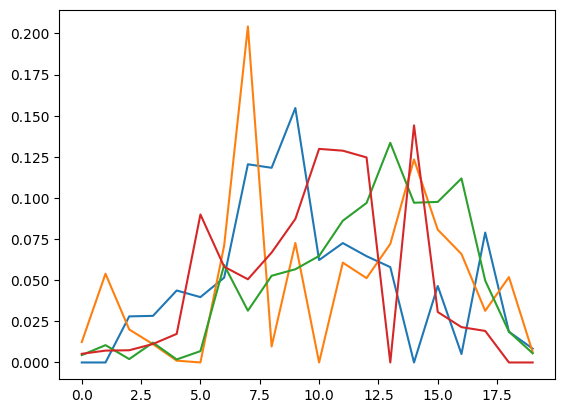

In [56]:
f_mean = np.mean(factors_probability.cpu().detach().numpy(), axis=0)
plt.plot(f_mean[0])
plt.plot(f_mean[1])
plt.plot(f_mean[2])
plt.plot(f_mean[3])
plt.show()

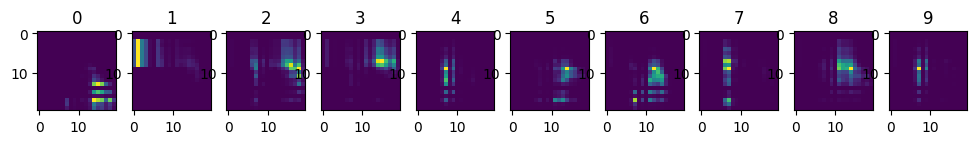

In [57]:
# plot
fig, axs = plt.subplots(1,10, figsize=(12,2))
for i in range(0,10):
    f1, f2 = factors_probability[::,0,::], factors_probability[::,1,::]
    probs = np.zeros((f1.shape[-1],f1.shape[-1]))
    # selecting the encoded distibution vectors
    f1_cls, f2_cls = f1[targets_test == i], f2[targets_test == i]
    for f1_vec, f2_vec in zip(f1_cls, f2_cls):
        probs += np.outer(f1_vec.cpu().detach().numpy(), f2_vec.cpu().detach().numpy())
            
    axs[i].imshow(probs)
#     axs[i].set_xticks(model.range.detach().numpy()/20)
#     axs[i].set_yticks(model.range.detach().numpy()/20)
    
    axs[i].set_title(f'{i}')

plt.savefig('MNIST_softmax_plus_2d_distribution.png')

plt.show()

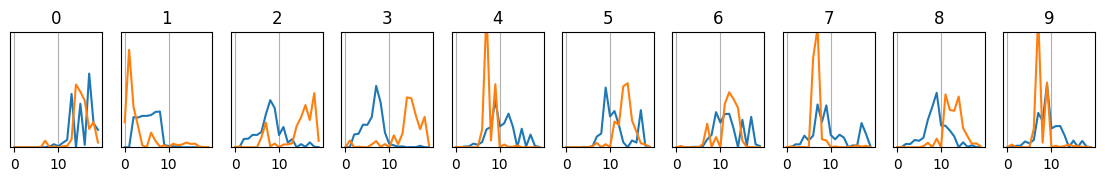

In [58]:
# plot
fig, axs = plt.subplots(1,10, figsize=(14,1.5), sharey=True)
for i in range(0,10):
    axs[i].plot(np.mean(factors_probability.cpu().detach().numpy()[targets_test == i], axis=0)[0])
    axs[i].plot(np.mean(factors_probability.cpu().detach().numpy()[targets_test == i], axis=0)[1])
    
    axs[i].grid(True)
    
    axs[i].set_yticks([])
    axs[i].set_ylim(0,0.5)

    axs[i].set_title(f'{i}')
plt.show()

### work with sampling 

In [60]:
#### work with sampling 

digit = 2
digit_X = X_full_test[targets_test == digit]

with torch.no_grad():
    model.eval()
    
    out, enc, factors_prob = inf_by_layers(model, digit_X.to(device))
    # out, enc, factors_prob = model(digit_X.unsqueeze(1).to(device))  
    # model(digit_X)
    
out = out.detach().cpu().squeeze().numpy() 
enc, factors_prob = enc.detach().cpu().numpy(), factors_prob.detach().cpu().numpy()
    

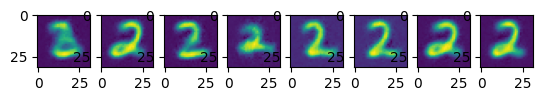

In [61]:
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(out[i*10])

In [66]:
normalized_factors = torch.from_numpy(factors_prob).to(device)
temperature = 0.01
eps1 = 1e-5
logit_factors = torch.log(normalized_factors+eps1) # analog of cumsum over bins
    

        
  
y = torch.rand(logit_factors.shape).to(device)
y = -torch.log(-torch.log(y + eps1) + eps1)


    
final_factors = torch.softmax((logit_factors + y)/temperature, dim=-1)
encoded = final_factors @ model.low_rank.grid




# decoding

decoded_rand = model.low_rank.decoder(encoded)
out_rand = decoded_rand.reshape(-1, 24, 24).detach().cpu().numpy()


C, H, W = 64, 3, 3
x_2d_rand = decoded_rand.view(decoded_rand.shape[0], C, H, W)
x_out_rand = model.up(x_2d_rand)
out_rand = x_out_rand.detach().cpu().numpy()

AttributeError: 'LowRankAutoencoder' object has no attribute 'grid'

NameError: name 'out_rand' is not defined

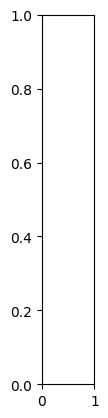

In [63]:
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(out_rand[i*10, 0])

In [ ]:
np.isnan(factor_j).sum()

NameError: name 'factor_j' is not defined

j = 0; Error:  0.13990299434839987
j = 1; Error:  0.0001386211314007696
j = 2; Error:  0.06230106167180622
j = 3; Error:  0.07287500118143833


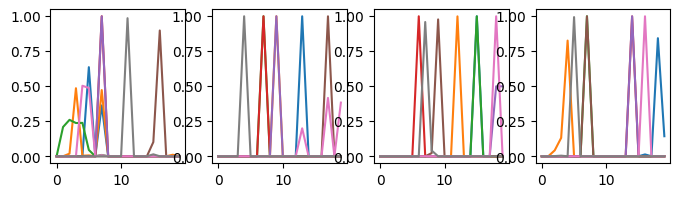

In [ ]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF

factor_rank = 8

comp_list = []
L = 4
plt.figure(figsize=[2*L, 2])
for j in range(L):
    nmf = NMF(n_components=factor_rank, max_iter=500, init='random')
    
    factor_j = factors_prob[:, j, :]
    # print(np.sum(factor_j))
    nmf.fit(factor_j)
    print(f"j = {j}; Error: ", nmf.reconstruction_err_/np.linalg.norm(factor_j))
    # u, sigma, v = np.linalg.svd(factor_j, full_matrices=False)
    components = nmf.components_
    # break
    # components = components.sum(0, keepdims=True)
    plt.subplot(1, L, j+1)
    plt.plot((components/components.sum(1, keepdims=True)).T)
    
    components = components.reshape(components.shape[0:1] + (1,1) + components.shape[1:2])

    comp_list += [components]
    

    

In [ ]:
normalized_factors_np = np.concatenate(comp_list, 2 )
normalized_factors_np = normalized_factors_np/(normalized_factors_np.sum(-1, keepdims=True))

normalized_factors_ = torch.from_numpy(normalized_factors_np).to(device)
normalized_factors_.shape

torch.Size([8, 1, 4, 20])

In [ ]:
torch.from_numpy(normalized_factors_np).to(device).sum(-1)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
# normalized_factors_ = torch.from_numpy(factors_prob[0:1]).to(device).unsqueeze(0)

In [ ]:

n_bins = 20
(encoded1.unsqueeze(-1).expand(encoded1.shape + (n_bins,)) == encoded1.unsqueeze(-1))[0,1,3,:]

tensor([True, True, True, True, True, True, False, False, True, True, True, True,
        True, True, False, False, True, False, False, False], device='cuda:0')

In [ ]:
encoded1.unsqueeze(-1).reshape(-1, 1).shape[0]

torch.Size([2048, 1])

In [ ]:
encoded1.unsqueeze(-1).reshape(-1, 1).shape[0]

2048

In [ ]:
mat_grid[indexes]

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
mask = torch.zeros(encoded1.shape + (20,)).to(device)
mask = mask.scatter_(0, encoded1.unsqueeze(-1), 1).to(torch.bool)
mask.shape

torch.Size([1, 512, 4, 20])

In [ ]:
mask[0, 0, 0, :].cpu()

tensor([False,  True,  True,  True,  True,  True, False, False,  True,  True,
         True,  True,  True,  True, False, False,  True,  True,  True,  True])

In [ ]:
encoded1.unsqueeze(-1)[0, 0, 0, :]

tensor([94664746603264], device='cuda:0')

In [ ]:

indexes = encoded1.unsqueeze(-1).reshape(-1, 1)
mat_grid = model.low_rank.range.unsqueeze(0).expand(indexes.shape[0], model.low_rank.range.shape[0])
torch.index_select(mat_grid, dim=1, index=indexes)


RuntimeError: Index is supposed to be an empty tensor or a vector

In [ ]:
torch.scatter(model.low_rank.range.reshape(1, 1, 1, 20).expand(1, 512, 1, 20).expand(1, 512, 4, 20), -1, encoded1.unsqueeze(-1))

TypeError: scatter() received an invalid combination of arguments - got (Tensor, int, Tensor), but expected one of:
 * (Tensor input, int dim, Tensor index, Tensor src, *, Tensor out)
 * (Tensor input, int dim, Tensor index, Tensor src, *, str reduce, Tensor out)
 * (Tensor input, name dim, Tensor index, Tensor src)
 * (Tensor input, int dim, Tensor index, Number value, *, Tensor out)
 * (Tensor input, int dim, Tensor index, Number value, *, str reduce, Tensor out)
 * (Tensor input, name dim, Tensor index, Number value)


In [ ]:
normalized_factors.shape

torch.Size([1, 4, 20])

In [ ]:
normalized_factors[0, 0, :]

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
normalized_factors.cpu().sum(-1)

tensor([[-3.6952e+16,  3.7478e+00, -6.2171e+16, -3.4834e-05]])

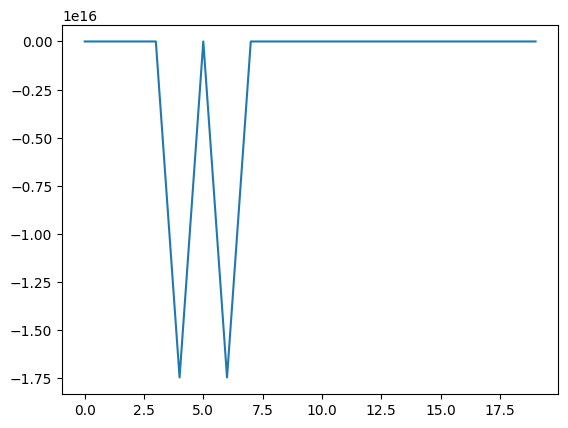

In [ ]:
plt.plot(cumsum_factors.cpu()[0, 0, :])

In [ ]:
# model.low_rank.range.reshape(1, 1, 1, 20).expand(1, 512, 1, 20).expand(1, 512, 4, 20).cpu()[encoded1.unsqueeze(-1).cpu()]

aa = model.low_rank.range.reshape(1, 1, 1, 20).expand(1, 512, 1, 20).expand(1, 512, 4, 20).detach().cpu()
b = encoded1.unsqueeze(-1).cpu().detach()
aa[b]


IndexError: index 52635820644892671 is out of bounds for dimension 0 with size 1

In [ ]:


temperature = GAMBEL_TEMPERATURE
eps1 = 1e-5

Nx, Ny = normalized_factors_.shape[0], 10
plt.figure(figsize=[10, 10])
for i in range(Nx ):
    for j in range(Ny):
        plt.subplot(Nx, Ny, i*Ny+j+1)
        normalized_factors = normalized_factors_[i]
        
        # # SOFTMAX version
        # B = BATCH_SIZE
        # cumsum_factors = torch.cumsum(normalized_factors, dim=-1) # cumsum over bins
        
        # NN = NN_SAMPLE if model.low_rank.training is True else 1
        
        # # encoded_list = []
        # # for _ in range(NN):
        # y = torch.rand(NN,B, model.low_rank.out_features,1).to(device)
        # abs_factors = torch.abs(cumsum_factors.unsqueeze(0) - y)
        # final_factors = torch.softmax(-300*abs_factors, dim=-1)
        # encoded1 = final_factors @ model.low_rank.range
        
        # # encoded_list.append(encoded1)
            
        # encoded = encoded1.reshape(-1, model.low_rank.out_features)
        # ##########################        
        
        
        # ### Gambell version
        # logit_factors = torch.log(normalized_factors+eps1) # analog of cumsum over bins

        # y = torch.rand(logit_factors.shape).to(device)
        # y = -torch.log(-torch.log(y + eps1) + eps1)
                


        # final_factors = torch.softmax((logit_factors + y)/temperature, dim=-1)
        # encoded = final_factors @ model.low_rank.range
        
        
        # #########################     
        
        
        ### Argmin version
        NN = 1
        B = BATCH_SIZE
        cumsum_factors = torch.cumsum(normalized_factors, dim=-1) # cumsum over bins
        break
    break
        
        y = torch.rand(NN, B, model.low_rank.out_features,1).to(device)
        abs_factors = torch.abs(cumsum_factors.unsqueeze(0) - y)
        # final_factors = torch.softmax(-300*abs_factors, dim=-1)
        # encoded1 = final_factors @ model.low_rank.range
        encoded1 = torch.argmin(abs_factors, dim=-1)
        encoded = encoded1.reshape(-1, model.low_rank.out_features)
    
        #########################  


                




        # decoding
        decoded_rand = model.low_rank.decoder(encoded)
        
        # ecoded_rand = model.low_rank.decoder(encoded)
        # out_rand = decoded_rand.reshape(-1, 24, 24).detach().cpu().numpy()


        C, H, W = 64, 3, 3
        x_2d_rand = decoded_rand.view(decoded_rand.shape[0], C, H, W)
        x_out_rand = model.up(x_2d_rand)
        out_rand = x_out_rand.detach().cpu().numpy()
        
        
        
        # out_rand = decoded_rand.reshape(24, 24).detach().cpu().numpy()
        
        
        plt.imshow(out_rand[0, 0])
        
    

IndentationError: unexpected indent (699102512.py, line 52)

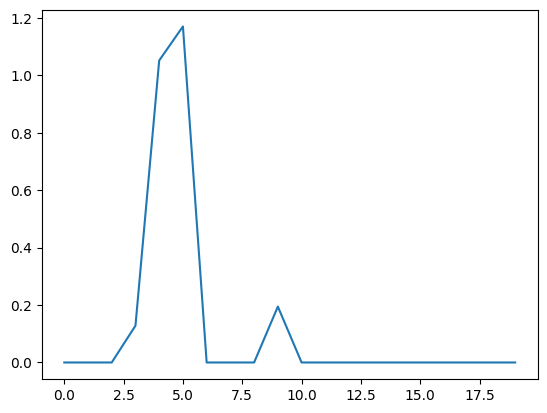

In [ ]:
plt.plot(nmf.components_[4])

### Classical sampling

In [ ]:
# forward whole dataset
with torch.no_grad():
    model.eval()
    # mnist
    decoded_2d1, encoded_out_dim1, factors_probability1 = inf_by_layers(model, X_full_test.to(device))
    decoded_2d2, encoded_out_dim2, factors_probability2 = inf_by_layers(model, X_full_train.to(device))   



In [39]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

enc_pca = pca.fit_transform(encoded_out_dim1.cpu().detach().numpy())
enc_pca1 = pca.fit_transform(encoded_out_dim2.cpu().detach().numpy())

# enc_pca = enc.detach().numpy()
# enc_pca1 = enc1.detach().numpy()

NameError: name 'encoded_out_dim1' is not defined

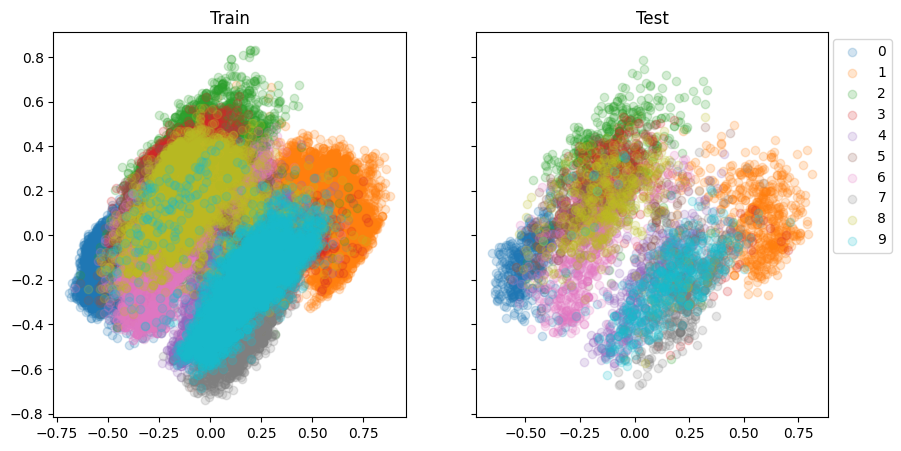

In [39]:
fig, axs = plt.subplots(1,2, figsize=(10,5), sharey=True)
for cls in [0,1,2,3,4,5,6,7,8,9]:
    # X_cur = enc.cpu().detach().numpy()[targets == cls]
    X_cur = enc_pca1[targets == cls]
    axs[0].scatter(X_cur[::,0], X_cur[::,1], label=cls, alpha=0.2)
    
    # X_cur1 = enc1.cpu().detach().numpy()[targets_test == cls]
    X_cur1 = enc_pca[targets_test == cls]
    axs[1].scatter(X_cur1[::,0], X_cur1[::,1], label=cls, alpha=0.2)

axs[0].set_title('Train')
axs[1].set_title('Test')
plt.legend(bbox_to_anchor=(1.2, 1))
# plt.xlim(-0.1,1.1)
# plt.ylim(-0.1,1.1)
plt.savefig('MNIST_softmax_plus_PCA.png')
plt.show()

In [40]:
EMB_SIZE = 4
PCA_SIZE = 2
pca = PCA(n_components=PCA_SIZE)
pca.fit(encoded_out_dim2.cpu().detach().numpy())
pca.transform(torch.randn(1,EMB_SIZE)*torch.std(encoded_out_dim2, dim=0).cpu()
               + torch.mean(encoded_out_dim2, dim=0).cpu())

array([[ 0.57326334, -0.28180658]])

In [41]:
enc_pca = pca.transform(encoded_out_dim2.cpu().detach().numpy())
mean_enc_pca = np.mean(enc_pca, axis=0)
std_enc_pca = np.std(enc_pca, axis=0)
print(mean_enc_pca)
print(std_enc_pca)

[-3.5966470e-05  3.4345383e-05]
[0.30477077 0.25437087]


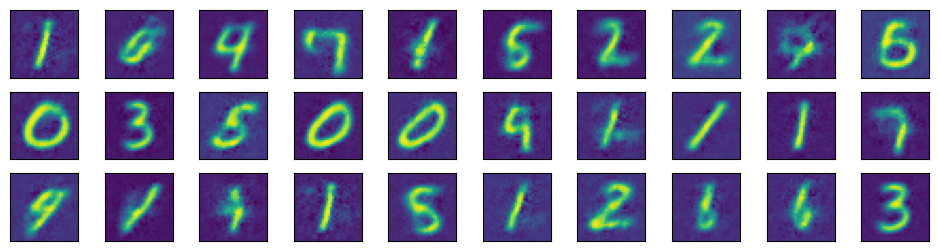

In [42]:
# plot
EMB_SIZE = 4

fig, axs = plt.subplots(3,10, figsize=(12,3))
for i in range(0,10):
    with torch.no_grad():
        model.eval()

        for j in range(3):
            rand = torch.rand(EMB_SIZE)
            x_down = model.down(x_batch)
            B, C, H, W = (1,64,4,4)
            decoded_inter_dim =         model.low_rank.intermediate_decoder(rand.to(device))
            decoded_1d =                model.low_rank.decoder(decoded_inter_dim)
            decoded_2d_small = decoded_1d.view(B, C, H, W)
            decoded_2d = model.up(decoded_2d_small)

            axs[j,i].imshow(decoded_2d.cpu().detach().numpy()[0,0])



    axs[0,i].set_xticks([])
    axs[0,i].set_yticks([])
    axs[1,i].set_xticks([])
    axs[1,i].set_yticks([])
    axs[2,i].set_xticks([])
    axs[2,i].set_yticks([])
#     axs[i].set_title(f'{i}')

plt.savefig('MNIST_softmax_plus_Generation.png')
plt.show()

### Classification test

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#### from factors_probability 

In [44]:
with torch.no_grad():
    model.eval()
    # Train
    x_batch = X_full_train.to(device)
    decoded_2d, encoded_out_dim, factors_probability = inf_by_layers(model, x_batch)
    prob_latent_train = factors_probability.reshape(factors_probability.shape[0], -1).detach().cpu()
    
    #Test
    x_batch = X_full_test.to(device)
    decoded_2d, encoded_out_dim, factors_probability = inf_by_layers(model, x_batch)
    prob_latent_test = factors_probability.reshape(factors_probability.shape[0], -1).detach().cpu()
    
    
# for j in range(factors_probability.shape[1]):
#     plt.plot(factors_probability[0, j, :].detach().cpu())

In [45]:
X_class_train, X_class_test = prob_latent_train, prob_latent_test

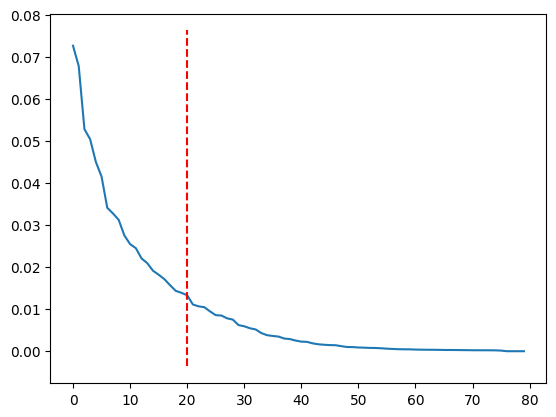

In [321]:
# Low rank
n_components = 20
pca_ = PCA(n_components=prob_latent_train.shape[-1])
pca_.fit(prob_latent_train)
plt.plot(pca_.explained_variance_)
plt.vlines([n_components], ymin = plt.gca().get_ylim()[0], ymax = plt.gca().get_ylim()[1], colors=['r'], linestyles=['--'])

pca_f = PCA(n_components=prob_latent_train.shape[-1]).fit(prob_latent_train)
X_class_train = pca_f.transform(prob_latent_train)
X_class_test= pca_f.transform(prob_latent_test)


#### from encoded_out_dim

In [53]:
with torch.no_grad():
    model.eval()
    # Train
    x_batch = X_full_train.to(device)
    decoded_2d, encoded_out_dim, factors_probability = inf_by_layers(model, x_batch)
    # prob_latent_train = factors_probability.reshape(factors_probability.shape[0], -1).detach().cpu()
    encoded_out_dim_train = encoded_out_dim.detach().cpu()
    
    #Test
    x_batch = X_full_test.to(device)
    decoded_2d, encoded_out_dim, factors_probability = inf_by_layers(model, x_batch)
    prob_latent_test = factors_probability.reshape(factors_probability.shape[0], -1).detach().cpu()
    encoded_out_dim_test = encoded_out_dim.detach().cpu()
    
   


In [55]:
X_class_train, X_class_test = encoded_out_dim_train, encoded_out_dim_test

In [54]:
(encoded_out_dim_train != X_class_train).sum()

tensor(194131)

#### Classification  

In [59]:
X_train, y_train = X_class_train, targets
X_test, y_test= X_class_test, targets_test

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)


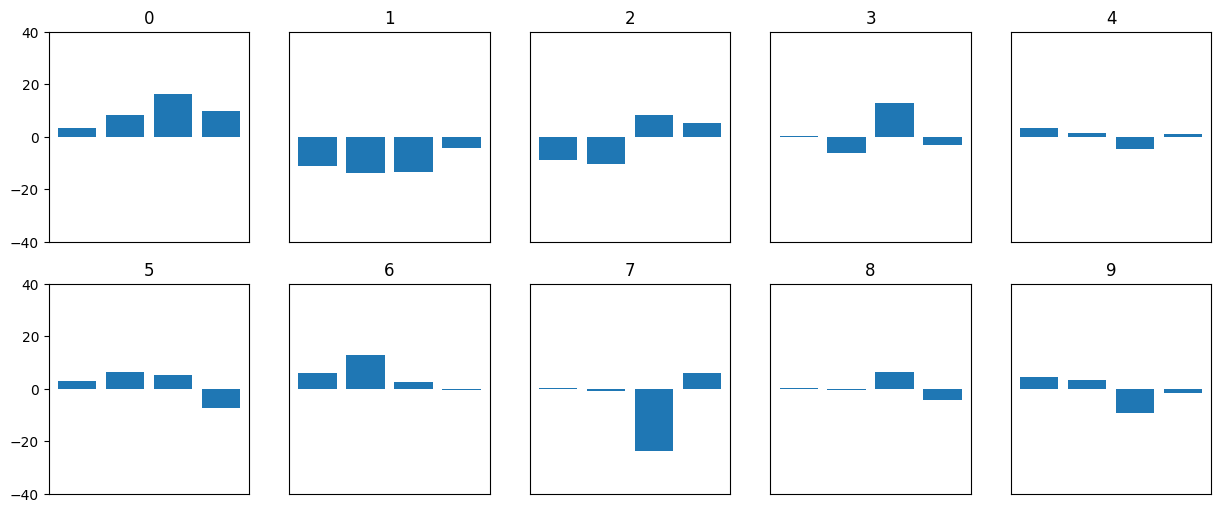

In [60]:
plt.figure(figsize=[15, 6])
nx, ny = 2, 5
for i in range(10):
    plt.subplot(nx, ny, i+1)
    plt.bar(np.arange(clf.coef_.shape[1])+1, clf.coef_[i, :])
    if i % ny != 0:
        plt.gca().set_yticks([])
        
    # plt.gca().set_yticks([-10, 0, 10])
    plt.gca().set_ylim([-40, 40])
    plt.gca().set_xticks([])
    # plt.grid()
    plt.title(str(i))

In [336]:
# for i in range(10):
#     plt.scatter(clf.coef_[i, 0], clf.coef_[i, 1],)

In [62]:
print(classification_report(y_train, y_pred_train))
print()
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.87      0.92      0.90      5923
           1       0.88      0.93      0.91      6742
           2       0.86      0.88      0.87      5958
           3       0.71      0.77      0.74      6131
           4       0.68      0.56      0.61      5842
           5       0.63      0.65      0.64      5421
           6       0.82      0.76      0.79      5918
           7       0.74      0.86      0.80      6265
           8       0.67      0.48      0.56      5851
           9       0.55      0.59      0.57      5949

    accuracy                           0.75     60000
   macro avg       0.74      0.74      0.74     60000
weighted avg       0.74      0.75      0.74     60000


              precision    recall  f1-score   support

           0       0.86      0.89      0.88       460
           1       0.87      0.90      0.88       571
           2       0.87      0.84      0.86       530
           3       0.65

Text(0.5, 1.0, 'Test')

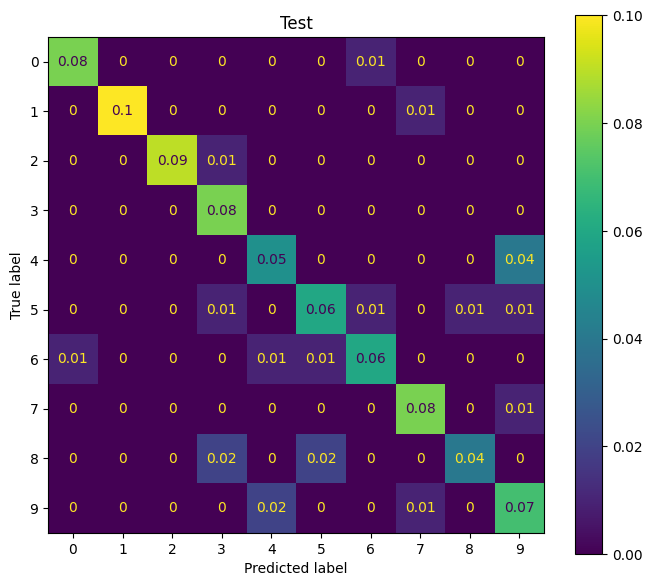

In [63]:
# plt.figure(figsize=[16, 4])

# # plt.subplot(1, 3, 1)
# plt.figure(figsize=[8, 7])
# cm = confusion_matrix(y_train, y_pred_train, labels=clf.classes_, normalize='all')
# disp = ConfusionMatrixDisplay(confusion_matrix=np.round(cm, 3), display_labels=clf.classes_)
# disp.plot(ax = plt.gca())
# plt.title('Train')
# plt.show()



# plt.subplot(1, 3, 2)
plt.figure(figsize=[8, 7])
cm = confusion_matrix(y_test, y_pred_test, labels=clf.classes_, normalize='all')
disp = ConfusionMatrixDisplay(confusion_matrix=np.round(cm, 2), display_labels=clf.classes_)
disp.plot(ax = plt.gca())
plt.title('Test')